In [1]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # for GBM

import operator # for sorting dictionaries

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in notebook
%matplotlib inline

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /home/acmankit/anaconda3/envs/py35/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgd7q09xc
  JVM stdout: /tmp/tmpgd7q09xc/h2o_acmankit_started_from_python.out
  JVM stderr: /tmp/tmpgd7q09xc/h2o_acmankit_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Madrid
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_acmankit_qy0xym
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [5]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

In [6]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [7]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
data[y] = data[y].asfactor() 

In [9]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [10]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


In [11]:
row = test[test['ID'] == 29116]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1


In [12]:
def generate_local_sample(row, frame, X, N=1000):
    
    """ Generates a perturbed sample around a row of interest.
    
    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
    
    Returns:
        Pandas DataFrame containing perturbed sample.
    
    """
    
    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].types.items():
        if val == 'enum': # 'enum' means categorical
            rs = np.random.RandomState(11111) # random seed for reproducibility
            draw = rs.choice(frame[key].levels()[0], size=(1, N))[0]
        else:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            loc = row[key][0, 0]
            sd = frame[key].sd()
            draw = rs.normal(loc, sd, (N, 1))
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large
        
        sample_frame[key] = draw
        
    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,9988.454213,female,graduate school,divorced,58.287510,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,...,5433.340804,6276.576876,8055.530587,7347.467911,1597.834490,0.000000,1000.000000,823.253257,0.000000,0.000000
1,181039.642122,male,high school,married,70.460689,pay duly,pay duly,pay duly,pay duly,use of revolving credit,...,94937.888614,90412.278099,87766.906051,85915.192926,22137.303918,25583.930273,21802.010398,20928.433066,19123.775929,22563.515833
2,20000.000000,male,university,single,43.284233,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,...,10672.000000,11201.000000,12721.000000,11946.000000,2800.000000,0.000000,1000.000000,2000.000000,0.000000,0.000000


In [13]:
# scaling and one-hot encoding for calculating Euclidian distance
# for the row of interest

# scale numeric
numeric = list(set(X) - set(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = test.as_data_frame()
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()
    
# encode categorical
row_df = scaled_test[scaled_test['ID'] == 22760]
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                               'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)

# convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
2.24639,0.481433,-0.66112,-0.657958,-0.651883,-0.637776,-0.622867,-0.609179,-0.360791,-0.282325,-0.315203,-0.319038,-0.319074,-0.270536,1,1,1,1,1,1,1,1,1


In [14]:
# scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])
perturbed_sample_dummies.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
-0.845634,-0.0955699,-0.84979,-0.845174,-0.845174,-0.83886,-0.834367,-0.834967,-0.83834,-0.723503,-0.722209,-0.849042,-0.723503,-0.723503,1,1,0,0,0,0,0,0,0
1.41903,1.2011,1.41949,1.41897,1.41897,1.4182,1.4176,1.41769,1.41814,1.41999,1.41993,1.41941,1.41999,1.41999,0,0,1,0,0,0,0,0,0
-0.713084,-1.69369,-0.716971,-0.712654,-0.712654,-0.706755,-0.70256,-0.70312,-0.706269,-0.723503,-0.722209,-0.716271,-0.723503,-0.723503,0,0,0,0,0,0,0,0,0


In [15]:
# calculate distance using H2OFrame distance function
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(rows=3)

distance
287.907
253.673
282.757


In [16]:
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
perturbed_sample.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757


In [17]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(perturbed_sample).drop(['predict', 'p0'])
preds1.columns = [yhat]
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907,0.515197
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673,0.0663977
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757,0.692681


In [18]:
# initialize
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance',
                                           seed=12345)
# train 
local_glm1.train(x=X, y=yhat, training_frame=perturbed_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
PAY_6.5 month delay:      0.00012336828327697705
PAY_6.8 month delay:      0.00017180686755602562
AGE:                      0.0005214813169893759
MARRIAGE.divorced:        0.0009908636978089515
PAY_5.5 month delay:      0.0029210607400959312
PAY_5.8 month delay:      0.0034766652812617737
MARRIAGE.married:         0.00839449832911553
EDUCATION.graduate school: 0.008778594515506156
PAY_4.8 month delay:      0.009194057851981784
PAY_6.2 month delay:      0.010989810282326163
PAY_3.8 month delay:      0.011784255155206258
PAY_4.4 month delay:      0.013724839005152558
PAY_2.8 month delay:      0.015148689640095393
PAY_3.4 month delay:      0.015894167507824828
EDUCATION.high school:    0.017278858933894182
PAY_0.8 month delay:      0.01866577067319948
PAY_2.4 month delay:      0.01883620843956382
PAY_5.2 month delay:      0.021213743679622924
PAY_0.4 month delay:      0.02226

In [21]:
def plot_local_contrib(row, model, X): 

    """ Plots reason codes in a bar chart. 
    
    Args:
    
        row: Row of H2OFrame to be explained.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.
    
    """
    
    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])
    
    # multiply values in row by local glm coefficients    
    for key, val in sorted(row[X].types.items()):
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]
        
        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 
    
    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 #color=''.join(local_contrib_frame.Sign.map({True:'b', False:'g'}).values), 
                                 legend=False) 
    

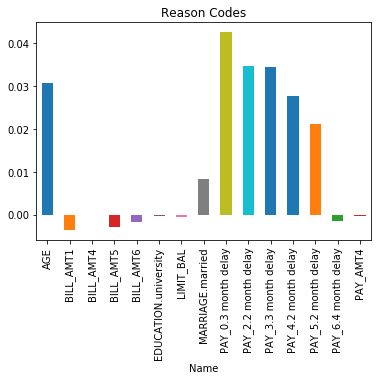

In [22]:
 plot_local_contrib(row, local_glm1, X)

In [23]:
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = [yhat]
practical_sample = test.cbind(preds2)
practical_sample = practical_sample[practical_sample['SEX'] == 'female']
practical_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205


In [24]:
# initialize
local_glm2 = H2OGeneralizedLinearEstimator(lambda_search=True, seed=12345)

# train 
local_glm2.train(x=X, y=yhat, training_frame=practical_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm2.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm2.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
BILL_AMT5:                1.1826997991308345e-07
BILL_AMT2:                1.40866409117354e-07
PAY_2.use of revolving credit: 8.019899530507052e-05
PAY_5.no consumption:     0.0005253910928260071
AGE:                      0.0005358697742774277
EDUCATION.high school:    0.001738945706593454
PAY_6.5 month delay:      0.003746060705692238
EDUCATION.university:     0.0050869233726203505
MARRIAGE.divorced:        0.008137713429375004
PAY_3.2 month delay:      0.009655714764721601
PAY_6.7 month delay:      0.009949478307751001
MARRIAGE.married:         0.010783461117748264
PAY_6.2 month delay:      0.017777285984771147
PAY_4.4 month delay:      0.018246956356881238
PAY_0.5 month delay:      0.02282693801079417
PAY_5.3 month delay:      0.02513913532234654
PAY_2.2 month delay:      0.027053294000875572
PAY_2.3 month delay:      0.027735314903293225
PAY_3.3 month delay:      0.03

glm prediction progress: |████████████████████████████████████████████████| 100%


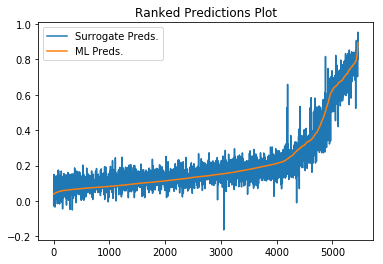

In [25]:
# ranked predictions plot
pred_frame = local_glm2.predict(practical_sample).cbind(practical_sample)\
                       .as_data_frame()[['predict', yhat  ]]

pred_frame.columns = ['Surrogate Preds.', 'ML Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

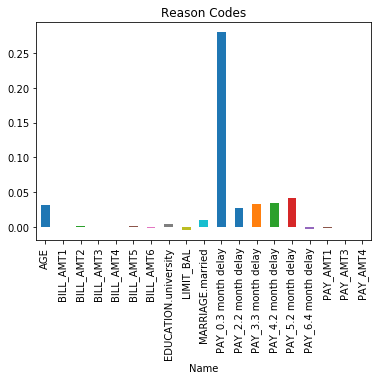

In [26]:
plot_local_contrib(row, local_glm2, X)     